In [1]:
#Importing and notebook setup
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimization


In [2]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/HD217014/HD217014.csv')

#Naming Variables from data
t = np.array(data.time)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)

#best fit time vector
time = np.linspace(t[0]-1,t[-1]+1,num=10000)

In [3]:
#Finding Best Fit Equation
def func(x, amp, period, vertical_shift,horizontal_shift):
    return amp*np.sin((period)*(x-horizontal_shift))+vertical_shift

#Parameters from best fit
param = optimization.curve_fit(func,t, vel)[0]

#Best Fit Fuction
best_fit = func(time, param[0], param[1], param[2],param[3])


print "Guess of Model"
print 'Amplitude: ', param[0]
print 'Period: ', param[1]
print 'H Shift: ', param[2]
print 'v Shift', param[3]

Guess of Model
Amplitude:  19.7720658754
Period:  1.00078175995
H Shift:  -1.90563964648
v Shift 12.6448317495


(13927.05042, 14027.05042)

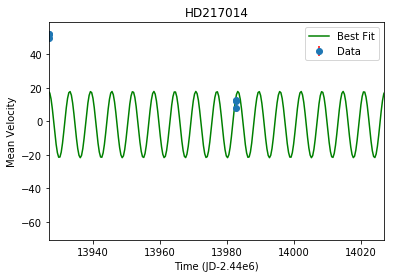

In [4]:
#Data Plotting with best fit
plt.figure()
plt.xlabel('Time (JD-2.44e6)')
plt.ylabel('Mean Velocity')
plt.errorbar(t,vel,yerr=errvel, fmt='o', ecolor='red', label='Data')
plt.plot(time,best_fit,color='green',label='Best Fit')
plt.title('HD217014')
plt.legend()
plt.xlim(t[0],t[0]+100)

(0, 8)

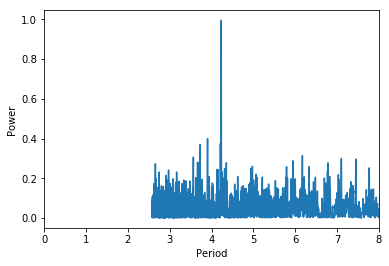

In [5]:
#using Lomb-Scargle Power (CORRECT)
#from gatspy
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(t, vel)
period, power = model.periodogram_auto(nyquist_factor=50)

#Plotting
plt.figure
plt.plot(period,power)
plt.ylabel('Power')
plt.xlabel('Period')# days
plt.xlim(0,8)

In [6]:
# set range and find period (Correct)
model.optimizer.period_range=(2, 8)
period = model.best_period
print("period = {0}".format(period))

Finding optimal frequency:
 - Estimated peak width = 0.00166
 - Using 5 steps per peak; omega_step = 0.000332
 - User-specified period range:  2 to 8
 - Computing periods at 7109 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 4.23078166873


In [7]:
# Example Keplerian fit configuration file
# Required packages for setup
import os
import pandas as pd
import numpy as np
import radvel

# Define global planetary system and dataset parameters
starname = 'HD217014'
nplanets = 1    # number of planets in the system
instnames = ['j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
ntels = len(instnames)       # number of instruments with unique velocity zero-points
fitting_basis = 'per tc secosw sesinw k'    # Fitting basis, see radvel.basis.BASIS_NAMES for available basis names
bjd0 = 2.44e6 + 13927.050417
planet_letters = {1: 'b'}

# Define prior centers (initial guesses) here.
params = radvel.RVParameters(nplanets,basis='per tc e w k')    # initialize RVparameters object

params['per1'] = 4.23078166873     # period of 1st planet
params['tc1'] = 2072.79438    # time of inferior conjunction of 1st planet
params['e1'] = 0.00          # eccentricity of 'per tc secosw sesinw logk'1st planet
params['w1'] = np.pi/2.      # argument of periastron of the star's orbit for 1st planet
params['k1'] = 20       # velocity semi-amplitude for 1st planet

params['dvdt'] = 0.0         # slope
params['curv'] = 0.0         # curvature

params['gamma_j'] = 1.0      # "                   "   hires_rj
params['jit_j'] = 2.6        # "      "   hires_rj


# Load radial velocity data, in this example the data is contained in an hdf file,
# the resulting dataframe or must have 'time', 'mnvel', 'errvel', and 'tel' keys
# path = os.path.join(radvel.DATADIR,'epic203771098.csv')
data = pd.read_csv('C:/users/rscsa/Research/radvel-master/HD217014/HD217014.csv')
data['time'] = data.time
data['mnvel'] = data.mnvel
data['errvel'] = data.errvel
data['tel'] = 'j'


In [8]:
# Set parameters to be held constant (default is for all parameters to vary). Must be defined in the fitting basis
vary = dict(
    #dvdt =False,
    curv = False,
    #jit_j = False,
    #per1 = False,
    #tc1 = False,
    #secosw1 =False,
    #sesinw1 = False,
    #e1=False,
    #w1=False,
)


# Define prior shapes and widths here.
priors = [
    radvel.prior.EccentricityPrior( nplanets ),           # Keeps eccentricity < 1
    radvel.prior.PositiveKPrior( nplanets ),             # Keeps K > 0
    radvel.prior.Gaussian('tc1', params['tc1'], 0.01), # Gaussian prior on tc1 with center at tc1 and width 0.01 days
    radvel.prior.Gaussian('per1', params['per1'], 0.01),
    radvel.prior.HardBounds('jit_j', 0.0, 15.0)
]


time_base = np.mean([np.min(data.time), np.max(data.time)])   # abscissa for slope and curvature terms (should be near mid-point of time baseline)

